# Training Random Forest Model to Predict Uber and Lyft Hourly Demand
Melissa Putri (1389438)

## Initialising

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("RF Training")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Increase driver memory
    .config("spark.executor.memory", "8g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/24 14:07:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load training and test sets
uber_train = spark.read.parquet('../data/curated/Uber_Train/')
uber_test = spark.read.parquet('../data/curated/Uber_Test/')
lyft_train = spark.read.parquet('../data/curated/Lyft_Train/')
lyft_test = spark.read.parquet('../data/curated/Lyft_Test')

## Random Forest Regression

### Initialising Hyperparameter Tuning and Cross-Validation for Random Forest Regressor Model

In [3]:
rf = RandomForestRegressor(featuresCol='features', labelCol='trip_count', numTrees=100)

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 150])    # Vary the number of trees
             .addGrid(rf.maxDepth, [5, 10, 15])       # Vary the max depth of the trees
             .addGrid(rf.maxBins, [32, 64])           # Vary the number of bins
             .build())

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="trip_count", metricName="rmse")

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

### Fit RF Model for Uber

In [4]:
uber_rf_model = crossval.fit(uber_train)
uber_rf_pred = uber_rf_model.transform(uber_test)

24/08/24 14:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1488.7 KiB
24/08/24 14:07:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/24 14:07:52 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/08/24 14:07:53 WARN DAGScheduler: Broadcasting large task binary with size 1438.2 KiB
24/08/24 14:07:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/08/24 14:07:54 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/08/24 14:07:55 WARN DAGScheduler: Broadcasting large task binary with size 1488.7 KiB
24/08/24 14:07:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/08/24 14:07:55 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/08/24 14:07:56 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/08/24 14:07:56 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/08/24 14:07:56 WARN DAGScheduler: Broadcas

### Fit RF Model for Lyft

In [5]:
# Train the model
lyft_cv_model = crossval.fit(lyft_train)

# Make predictions
lyft_rf_pred = lyft_cv_model.transform(lyft_test)

24/08/24 14:11:19 WARN DAGScheduler: Broadcasting large task binary with size 1447.1 KiB
24/08/24 14:11:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/08/24 14:11:19 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/08/24 14:11:20 WARN DAGScheduler: Broadcasting large task binary with size 1433.5 KiB
24/08/24 14:11:21 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/08/24 14:11:21 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/08/24 14:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1447.1 KiB
24/08/24 14:11:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/08/24 14:11:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/08/24 14:11:23 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/08/24 14:11:23 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/08/24 14:11:23 WARN DAGScheduler: Broadcas

## Linear Regression

In [6]:
# Initialize the Linear Regression models
lr = LinearRegression(featuresCol='features', labelCol='trip_count')

# Regularization Models
ridge_lr = LinearRegression(featuresCol='features', labelCol='trip_count', regParam=0.1, elasticNetParam=0.0)
lasso_lr = LinearRegression(featuresCol='features', labelCol='trip_count', regParam=0.1, elasticNetParam=1.0)


### Fit LR Model for Uber

In [7]:
# Train the models
uber_lr_model = lr.fit(uber_train)
uber_lr_pred = uber_lr_model.transform(uber_test)

# Ridge Regression (L2 regularization)
uber_ridge_model = ridge_lr.fit(uber_train)
uber_ridge_pred = uber_ridge_model.transform(uber_test)

# Lasso Regression (L1 regularization)
uber_lasso_model = lasso_lr.fit(uber_train)
uber_lasso_pred = uber_lasso_model.transform(uber_test)


24/08/24 14:14:43 WARN Instrumentation: [6895b371] regParam is zero, which might cause numerical instability and overfitting.
24/08/24 14:14:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/24 14:14:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/08/24 14:14:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/08/24 14:14:43 WARN Instrumentation: [6895b371] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


### Fit LR Model for Lyft

In [8]:
# Train the model
lyft_lr_model = lr.fit(lyft_train)

# Make predictions
lyft_lr_pred = lyft_lr_model.transform(lyft_test)

# Ridge Regression (L2 regularization)
lyft_ridge_model = ridge_lr.fit(lyft_train)
lyft_ridge_pred = lyft_ridge_model.transform(lyft_test)

# Lasso Regression (L1 regularization)
lyft_lasso_model = lasso_lr.fit(lyft_train)
lyft_lasso_pred = lyft_lasso_model.transform(lyft_test)


24/08/24 14:14:44 WARN Instrumentation: [2c6d2d9e] regParam is zero, which might cause numerical instability and overfitting.
24/08/24 14:14:45 WARN Instrumentation: [2c6d2d9e] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


# Evaluate Models

In [9]:
rmse_evaluator = RegressionEvaluator(labelCol='trip_count', predictionCol='prediction', metricName='rmse')
mae_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="trip_count", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol='trip_count', predictionCol='prediction', metricName='r2')

## Diagnostics

### Uber RF

In [10]:
uber_rmse_rf = rmse_evaluator.evaluate(uber_rf_pred)
print(f"RMSE for Uber Random Forest Regressor: {uber_rmse_rf}")

uber_rf_mae = mae_evaluator.evaluate(uber_rf_pred)
print(f"MAE for Uber Random Forest Regressor: {uber_rf_mae}")

uber_r2_rf = r2_evaluator.evaluate(uber_rf_pred)
print(f"R2 for Uber Random Forest Regressor: {uber_r2_rf}")

RMSE for Uber Random Forest Regressor: 5534.687669518426
MAE for Uber Random Forest Regressor: 4161.567516954648
R2 for Uber Random Forest Regressor: 0.9446721235856987


### Uber LR

In [11]:
# Uber Linear Regression
uber_rmse_lr = rmse_evaluator.evaluate(uber_lr_pred)
print(f"RMSE for Uber Linear Regression: {uber_rmse_lr}")

uber_lr_mae = mae_evaluator.evaluate(uber_lr_pred)
print(f"MAE for Uber Linear Regression: {uber_lr_mae}")

uber_r2_lr = r2_evaluator.evaluate(uber_lr_pred)
print(f"R2 for Uber Linear Regression: {uber_r2_lr}")

# Evaluate the Ridge Regression model
uber_rmse_ridge = rmse_evaluator.evaluate(uber_ridge_pred)
uber_r2_ridge = r2_evaluator.evaluate(uber_ridge_pred)
print(f"Ridge RMSE: {uber_rmse_ridge}")
print(f"Ridge R²: {uber_r2_ridge}")

# Evaluate the Lasso Regression model
uber_rmse_lasso = rmse_evaluator.evaluate(uber_lasso_pred)
uber_r2_lasso = r2_evaluator.evaluate(uber_lasso_pred)
print(f"Lasso RMSE: {uber_rmse_lasso}")
print(f"Lasso R²: {uber_r2_lasso}")

RMSE for Uber Linear Regression: 12653.408589542914
MAE for Uber Linear Regression: 10093.208707515536
R2 for Uber Linear Regression: 0.7108169529507706
Ridge RMSE: 12653.406967545701
Ridge R²: 0.7108170270895393
Lasso RMSE: 12653.388288370474
Lasso R²: 0.7108178808825849


### Lyft RF

In [12]:
# Evaluate the model
lyft_rmse_rf = rmse_evaluator.evaluate(lyft_rf_pred)
print(f"RMSE for Lyft Random Forest Regressor: {lyft_rmse_rf}")

lyft_rf_mae = mae_evaluator.evaluate(lyft_rf_pred)
print(f"MAE for Lyft Random Forest Regressor: {lyft_rf_mae}")

lyft_r2_rf = r2_evaluator.evaluate(lyft_rf_pred)
print(f"R2 for Lyft Random Forest Regressor: {lyft_r2_rf}")

RMSE for Lyft Random Forest Regressor: 1931.685565205145
MAE for Lyft Random Forest Regressor: 1452.5423533880362
R2 for Lyft Random Forest Regressor: 0.9371720911610179


### Lyft LR

In [13]:
# Evaluate the model
lyft_rmse_lr = rmse_evaluator.evaluate(lyft_lr_pred)
print(f"RMSE for Lyft Linear Regression: {lyft_rmse_lr}")

lyft_lr_mae = mae_evaluator.evaluate(lyft_lr_pred)
print(f"MAE for Lyft Linear Regression: {lyft_lr_mae}")

lyft_r2_lr = r2_evaluator.evaluate(lyft_lr_pred)
print(f"R2 for Lyft Linear Regression: {lyft_r2_lr}")

# Evaluate the Ridge Regression model
lyft_rmse_ridge = rmse_evaluator.evaluate(lyft_ridge_pred)
lyft_r2_ridge = r2_evaluator.evaluate(lyft_ridge_pred)
lyft_mae_ridge = mae_evaluator.evaluate(lyft_ridge_pred)
print(f"Ridge RMSE: {lyft_rmse_ridge}")
print(f"Ridge MAE: {lyft_mae_ridge}")
print(f"Ridge R²: {lyft_r2_ridge}")

# Evaluate the Lasso Regression model
lyft_rmse_lasso = rmse_evaluator.evaluate(lyft_lasso_pred)
lyft_r2_lasso = r2_evaluator.evaluate(lyft_lasso_pred)
lyft_mae_lasso = mae_evaluator.evaluate(lyft_lasso_pred)
print(f"Lasso RMSE: {lyft_rmse_lasso}")
print(f"Lasso MAE: {lyft_mae_lasso}")
print(f"Lasso R²: {lyft_r2_lasso}")

RMSE for Lyft Linear Regression: 4805.704813657053
MAE for Lyft Linear Regression: 3810.8314057956445
R2 for Lyft Linear Regression: 0.6111394212919525
Ridge RMSE: 4805.701974374111
Ridge MAE: 3810.826421002841
Ridge R²: 0.6111398807812154
Lasso RMSE: 4805.6976357216145
Lasso MAE: 3810.7983914249835
Lasso R²: 0.6111405829172092


## Plotting Model Performance

### Comparing Uber Models Performance

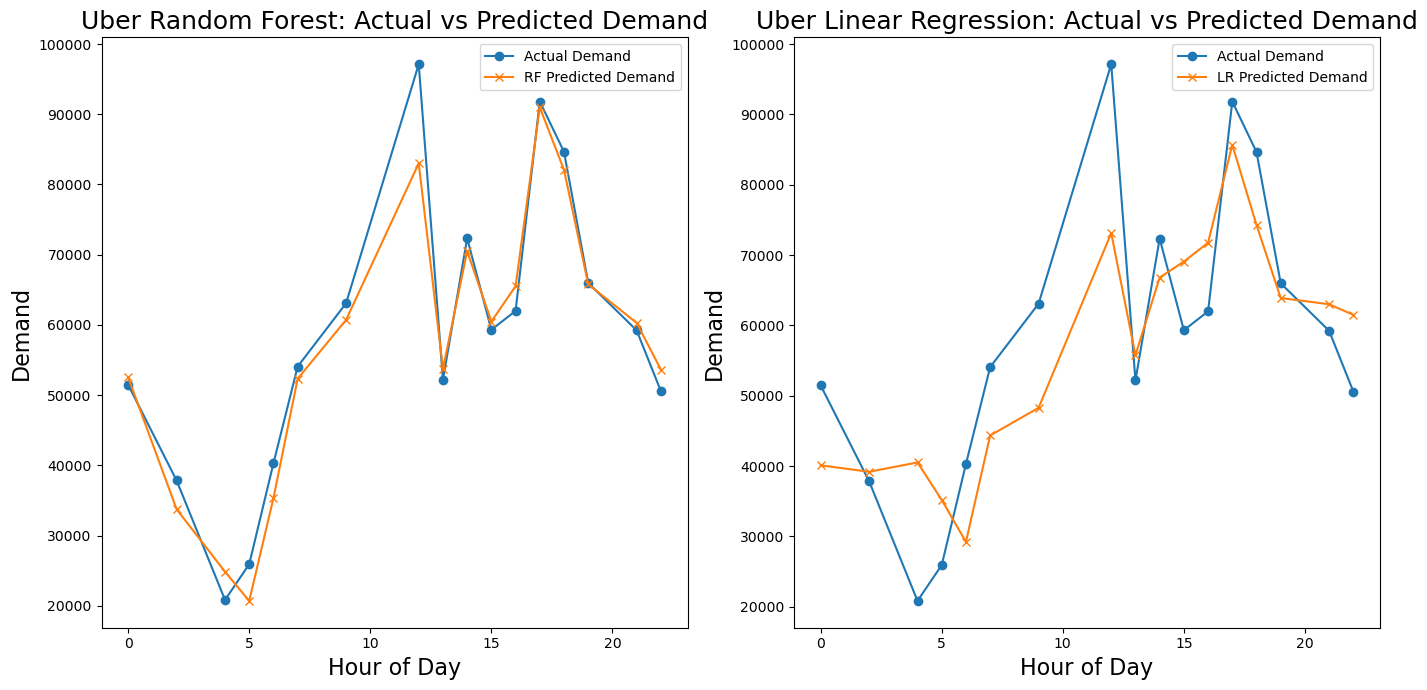

In [14]:
# Sample the predictions to reduce memory usage
uber_rf_pred_sample = uber_rf_pred.sample(withReplacement=False, fraction=0.1, seed=42)
uber_lr_pred_sample = uber_lr_pred.sample(withReplacement=False, fraction=0.1, seed=42)

# Convert sampled Spark DataFrame to Pandas DataFrame for plotting
uber_rf_pred_pd = uber_rf_pred_sample.select('hour', 'trip_count', 'prediction').toPandas()
uber_lr_pred_pd = uber_lr_pred_sample.select('hour', 'trip_count', 'prediction').toPandas()

# Aggregate predictions by hour for visualization
uber_rf_hourly = uber_rf_pred_pd.groupby('hour').agg({'trip_count': 'mean', 'prediction': 'mean'}).reset_index()
uber_lr_hourly = uber_lr_pred_pd.groupby('hour').agg({'trip_count': 'mean', 'prediction': 'mean'}).reset_index()

# Plot the results
plt.figure(figsize=(14, 7))

# Plot Random Forest predictions vs actual
plt.subplot(1, 2, 1)
plt.plot(uber_rf_hourly['hour'], uber_rf_hourly['trip_count'], label='Actual Demand', marker='o')
plt.plot(uber_rf_hourly['hour'], uber_rf_hourly['prediction'], label='RF Predicted Demand', marker='x')
plt.title('Uber Random Forest: Actual vs Predicted Demand',fontsize=18)
plt.xlabel('Hour of Day',fontsize=16)
plt.ylabel('Demand',fontsize=16)
plt.legend()

# Plot Linear Regression predictions vs actual
plt.subplot(1, 2, 2)
plt.plot(uber_lr_hourly['hour'], uber_lr_hourly['trip_count'], label='Actual Demand', marker='o')
plt.plot(uber_lr_hourly['hour'], uber_lr_hourly['prediction'], label='LR Predicted Demand', marker='x')
plt.title('Uber Linear Regression: Actual vs Predicted Demand', fontsize=18)
plt.xlabel('Hour of Day',fontsize=16)
plt.ylabel('Demand',fontsize=16)
plt.legend()

plt.tight_layout()
plt.show()


### Comparing Lyft Models Performance

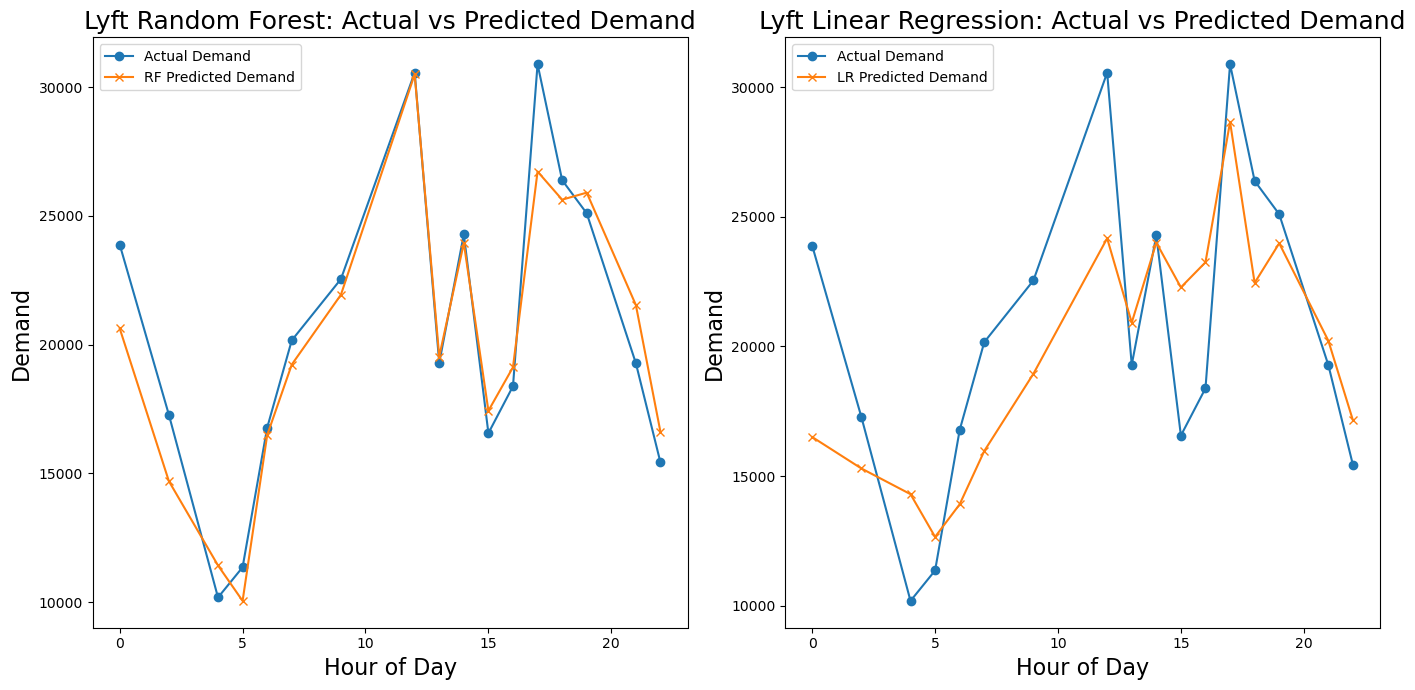

In [15]:
# Sample the predictions to reduce memory usage
lyft_rf_pred_sample = lyft_rf_pred.sample(withReplacement=False, fraction=0.1, seed=42)
lyft_lr_pred_sample = lyft_lr_pred.sample(withReplacement=False, fraction=0.1, seed=42)

# Convert sampled Spark DataFrame to Pandas DataFrame for plotting
lyft_rf_pred_pd = lyft_rf_pred_sample.select('hour', 'trip_count', 'prediction').toPandas()
lyft_lr_pred_pd = lyft_lr_pred_sample.select('hour', 'trip_count', 'prediction').toPandas()

# Aggregate predictions by hour for visualization
lyft_rf_hourly = lyft_rf_pred_pd.groupby('hour').agg({'trip_count': 'mean', 'prediction': 'mean'}).reset_index()
lyft_lr_hourly = lyft_lr_pred_pd.groupby('hour').agg({'trip_count': 'mean', 'prediction': 'mean'}).reset_index()

# Plot the results
plt.figure(figsize=(14, 7))

# Plot Random Forest predictions vs actual
plt.subplot(1, 2, 1)
plt.plot(lyft_rf_hourly['hour'], lyft_rf_hourly['trip_count'], label='Actual Demand', marker='o')
plt.plot(lyft_rf_hourly['hour'], lyft_rf_hourly['prediction'], label='RF Predicted Demand', marker='x')
plt.title('Lyft Random Forest: Actual vs Predicted Demand', fontsize=18)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Demand',fontsize = 16)
plt.legend()

# Plot Linear Regression predictions vs actual
plt.subplot(1, 2, 2)
plt.plot(lyft_lr_hourly['hour'], lyft_lr_hourly['trip_count'], label='Actual Demand', marker='o')
plt.plot(lyft_lr_hourly['hour'], lyft_lr_hourly['prediction'], label='LR Predicted Demand', marker='x')
plt.title('Lyft Linear Regression: Actual vs Predicted Demand', fontsize=18)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Demand', fontsize=16)
plt.legend()

plt.tight_layout()
plt.show()


### Comparing Uber vs. Lyft Demand Forecasts

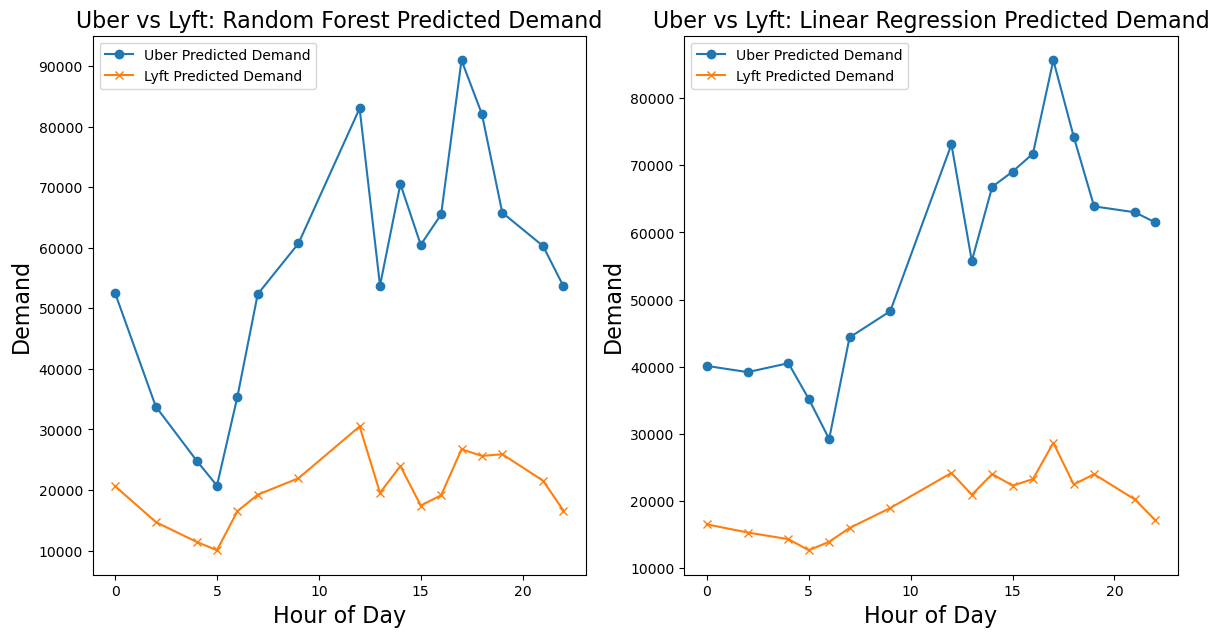

In [16]:
# Plot the results
plt.figure(figsize=(14, 7))

# Plot Random Forest predictions vs actual
plt.subplot(1,2,1)
plt.plot(uber_rf_hourly['hour'], uber_rf_hourly['prediction'], label='Uber Predicted Demand', marker='o')
plt.plot(lyft_rf_hourly['hour'], lyft_rf_hourly['prediction'], label='Lyft Predicted Demand', marker='x')
plt.title('Uber vs Lyft: Random Forest Predicted Demand', fontsize=16)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Demand', fontsize=16)
plt.legend()

# Plot Random Forest predictions vs actual
plt.subplot(1,2,2)
plt.plot(uber_lr_hourly['hour'], uber_lr_hourly['prediction'], label='Uber Predicted Demand', marker='o')
plt.plot(lyft_lr_hourly['hour'], lyft_lr_hourly['prediction'], label='Lyft Predicted Demand', marker='x')
plt.title('Uber vs Lyft: Linear Regression Predicted Demand', fontsize=16)
plt.xlabel('Hour of Day',fontsize=16)
plt.ylabel('Demand', fontsize=16)
plt.legend()

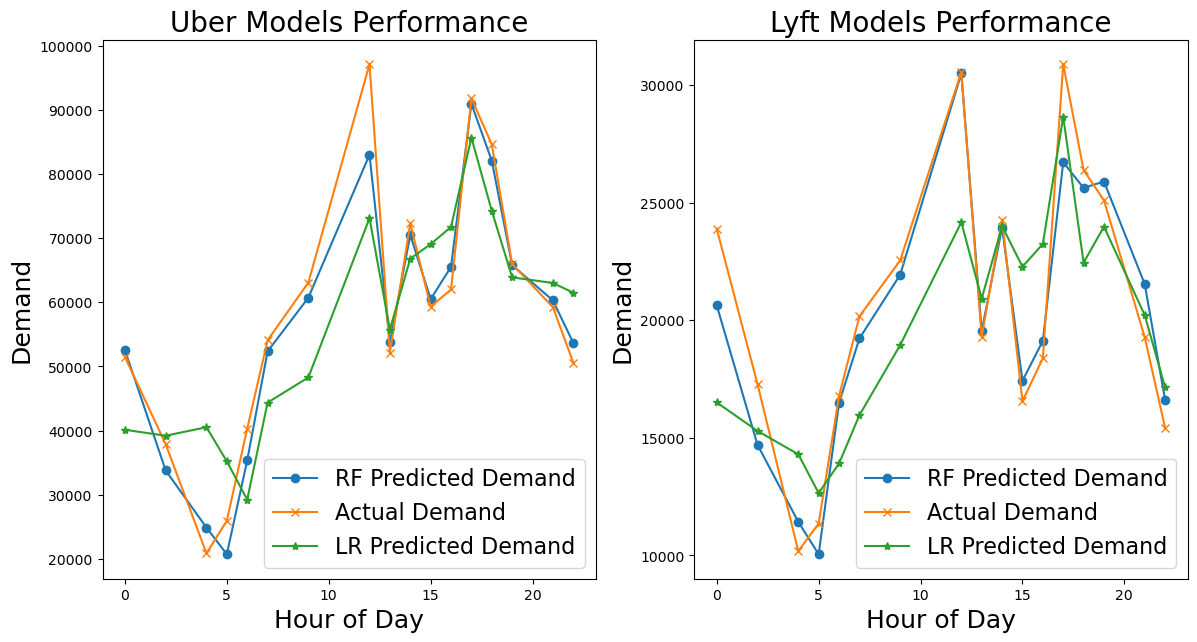

In [17]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.plot(uber_rf_hourly['hour'], uber_rf_hourly['prediction'], label='RF Predicted Demand', marker='o')
plt.plot(uber_rf_hourly['hour'], uber_rf_hourly['trip_count'], label='Actual Demand', marker='x')
plt.plot(uber_lr_hourly['hour'], uber_lr_hourly['prediction'], label='LR Predicted Demand', marker='*')
plt.title('Uber Models Performance', fontsize=20)
plt.xlabel('Hour of Day', fontsize=18)
plt.ylabel('Demand', fontsize=18)
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(lyft_rf_hourly['hour'], lyft_rf_hourly['prediction'], label='RF Predicted Demand', marker='o')
plt.plot(lyft_lr_hourly['hour'], lyft_lr_hourly['trip_count'], label='Actual Demand', marker='x')
plt.plot(lyft_lr_hourly['hour'], lyft_lr_hourly['prediction'], label='LR Predicted Demand', marker='*')
plt.title('Lyft Models Performance', fontsize=20)
plt.xlabel('Hour of Day', fontsize=18)
plt.ylabel('Demand', fontsize=18)
plt.legend(fontsize=16)